In [72]:
from neurodiffeq import diff
from neurodiffeq.solvers import Solver1D, Solver2D
from neurodiffeq.conditions import IVP, DirichletBVP2D
from neurodiffeq.networks import FCNN, SinActv, Resnet
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import torch
import torch.nn as nn
from neurodiffeq.generators import Generator1D

In [73]:
m = 1.0  # Mass of pendulum 1 and 2
l = 1.0  # Length of pendulum
g = 1.0   # Acceleration due to gravity
k = m*l*l #ml2

In [111]:
def double_pendulum(t, y, L1, L2, m1, m2, g):
    theta1, z1, theta2, z2 = y

    c, s = np.cos(theta1-theta2), np.sin(theta1-theta2)

    theta1dot = z1
    z1dot = (m2*g*np.sin(theta2)*c - m2*s*(L1*z1**2*c + L2*z2**2) -
             (m1+m2)*g*np.sin(theta1)) / L1 / (m1 + m2*s**2)
    theta2dot = z2
    z2dot = ((m1+m2)*(L1*z1**2*s - g*np.sin(theta2) + g*np.sin(theta1)*c) + 
             m2*L2*z2**2*s*c) / L2 / (m1 + m2*s**2)
    return theta1dot, z1dot, theta2dot, z2dot

In [107]:
def ode_system(theta_1, theta_2, p1, p2, t): 
    c = torch.cos(theta_1-theta_2)
    s = torch.sin(theta_1-theta_2)
    return [diff(theta_1,t)-(6/k)*(2*p1-3*c*p2)/(16-9*c*c), diff(theta_2,t)-(6/k)*(8*p2-3*c*p1)/(16-9*c*c), diff(p1,t)+(k/2)*(diff(theta_1,t)*diff(theta_2,t)*s+3*g*torch.sin(theta_1)/l), diff(p2,t)+(k/2)*(-diff(theta_1,t)*diff(theta_2,t)*torch.sin(theta_2)+g*s/l)]

conditions = [IVP(t_0=0.0, u_0=np.pi/4), IVP(t_0=0.0, u_0=np.pi/4), IVP(t_0=0.0, u_0=0.0), IVP(t_0=0.0, u_0=0.0)]
net_ho = FCNN(
    n_input_units=1,
    n_output_units=1,
    hidden_units=(32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32,32),
    actv=SinActv,
)

# nets = [FCNN(actv=SinActv), FCNN(actv=SinActv), FCNN(actv=SinActv), FCNN(actv=SinActv)]
g1 = Generator1D(size=1000, t_min=0.1, t_max=5.0, method='equally-spaced')
nets = [net_ho,net_ho,net_ho,net_ho]
# nets = [Resnet(actv=SinActv),Resnet(actv=SinActv),Resnet(actv=SinActv),Resnet(actv=SinActv)]

# solver = Solver1D(ode_system, conditions, t_min=0.1, t_max=5.0, nets = nets, train_generator=g1, valid_generator=g1)
solver = Solver1D(ode_system, conditions, t_min=0.1, t_max=5.0, nets = nets, train_generator=g1, valid_generator=g1)
solver.fit(max_epochs=1000)
solution = solver.get_solution()

Training Progress:   0%|                                                                                   | 0…

In [115]:
t = np.linspace(0.1, 5.0, 10000)
theta_1, theta_2, p1, p2 = solution(t, to_numpy=True)

In [116]:
initial_conditions = [np.pi/4,0.0,np.pi/4,0.0]
# Time span
t_span = (0.1, 5.0)
t_eval = np.linspace(t_span[0], t_span[1], 10000)

# Solve the differential equations using RK4
sol = solve_ivp(
    double_pendulum,
    t_span,
    initial_conditions,
    args=(l, l, m, m, g),
    t_eval=t_eval,
    method='RK45'
)

# Extract the solution
theta1_an = sol.y[0]
theta2_an = sol.y[1]

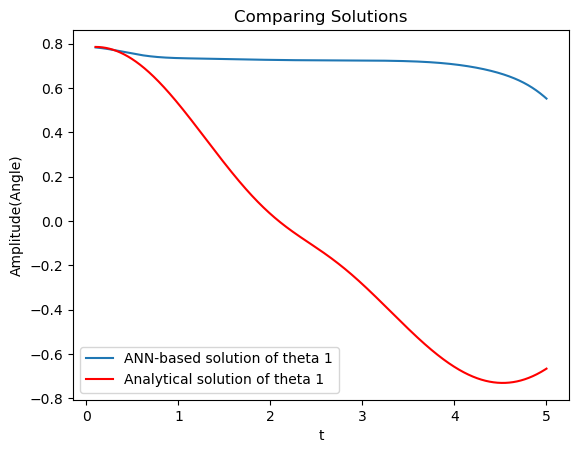

In [117]:
plt.title("Comparing Solutions")
plt.ylabel('Amplitude(Angle)')
plt.xlabel('t')
plt.plot(t, theta_1, label='ANN-based solution of theta 1')
plt.plot(t,theta1_an,label='Analytical solution of theta 1', color = 'r')
# plt.plot(t, theta2, label='ANN-based solution of theta 2')
# plt.scatter(t,theta2_an,label='Analytical solution of theta 2',marker=".")
plt.legend()
plt.show()